In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# load csv
df = pd.read_csv('FETAL_PLANES_DB_data.csv', delimiter=';')
df.head()


,Image_name,Patient_num,Plane,Brain_plane,Operator,US_Machine,Train
0,Patient00001_Plane1_1_of_15,1,Other,Not A Brain,Other,Aloka,1
1,Patient00001_Plane1_2_of_15,1,Other,Not A Brain,Other,Aloka,1
2,Patient00001_Plane1_3_of_15,1,Other,Not A Brain,Other,Aloka,1
3,Patient00001_Plane1_4_of_15,1,Other,Not A Brain,Other,Aloka,1
4,Patient00001_Plane1_5_of_15,1,Other,Not A Brain,Other,Aloka,1


In [3]:
# subsetting the rows related to 'Fetal brain'
df = df[df['Plane'] == 'Fetal brain']

# check unique categories under brain plane
df['Brain_plane'].unique()


array(['Trans-thalamic', 'Trans-cerebellum', 'Trans-ventricular', 'Other'],
      dtype=object)

In [4]:
# remove the 'Other'
df = df[df['Brain_plane']!='Other'].reset_index()

# keep necessary columns
df = df[['Image_name', 'Brain_plane', 'US_Machine']]
df.head()


,Image_name,Brain_plane,US_Machine
0,Patient00168_Plane3_1_of_3,Trans-thalamic,Aloka
1,Patient00168_Plane3_2_of_3,Trans-thalamic,Aloka
2,Patient00168_Plane3_3_of_3,Trans-cerebellum,Aloka
3,Patient00188_Plane3_1_of_3,Trans-thalamic,Aloka
4,Patient00188_Plane3_2_of_3,Trans-ventricular,Aloka


In [5]:
labels_dict = {
    'Trans-thalamic': 0,
    'Trans-cerebellum': 1,
    'Trans-ventricular': 2
}

# replace text with labels
df['Brain_plane'] = df['Brain_plane'].apply(lambda x: labels_dict[x])
df.head()


,Image_name,Brain_plane,US_Machine
0,Patient00168_Plane3_1_of_3,0,Aloka
1,Patient00168_Plane3_2_of_3,0,Aloka
2,Patient00168_Plane3_3_of_3,1,Aloka
3,Patient00188_Plane3_1_of_3,0,Aloka
4,Patient00188_Plane3_2_of_3,2,Aloka


In [6]:
# check unique machines
df['US_Machine'].unique()


array(['Aloka', 'Voluson E6', 'Voluson S10', 'Other'], dtype=object)

In [7]:
# check the counts for each machine type and brain place
df.groupby(['US_Machine', 'Brain_plane'])['Brain_plane'].count()


US_Machine   Brain_plane
Aloka        0               360
             1               134
             2               112
Other        0                83
             1                20
             2                18
Voluson E6   0              1072
             1               492
             2               408
Voluson S10  0               123
             1                68
             2                59
Name: Brain_plane, dtype: int64

In [8]:
# check total counts for each machine type
df.groupby('US_Machine')['Brain_plane'].count()


US_Machine
Aloka           606
Other           121
Voluson E6     1972
Voluson S10     250
Name: Brain_plane, dtype: int64

In [9]:
# plot images for different machines to observe differences
def show_imgs(machine_type, brain_plane, df=df):
    """
    plot the first 12 images of the selected machine type
    and brain plane
    """
    rows = df[(df['US_Machine']==machine_type) & 
              (df['Brain_plane']==brain_plane)].iloc[:12]
    fig = plt.figure(figsize=(12, 4))
    for idx in np.arange(12):
        ax = fig.add_subplot(2, 6, idx+1, xticks=[], yticks=[])
        labels = brain_plane
        ax.title.set_text(labels)
        img_path = 'Images/' + rows['Image_name'].values[idx] + '.png'
        img = Image.open(img_path)
        ax.imshow(img, cmap='gray')
    plt.show()
    plt.clf()


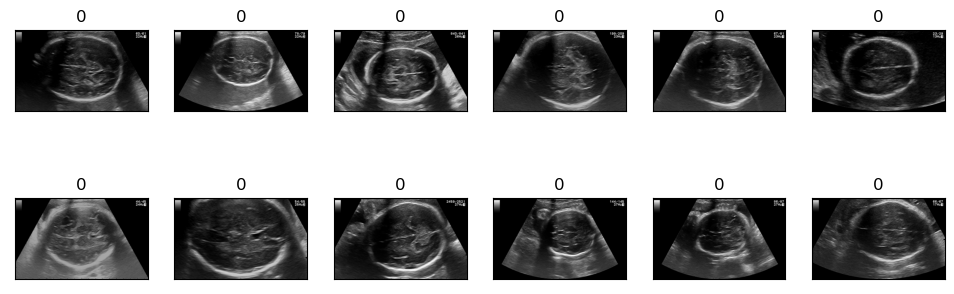

<Figure size 640x480 with 0 Axes>

In [10]:
show_imgs('Aloka', 0)

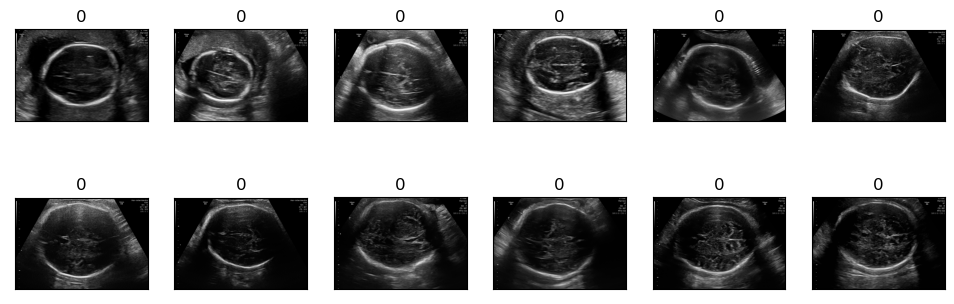

<Figure size 640x480 with 0 Axes>

In [11]:
show_imgs('Voluson E6', 0)

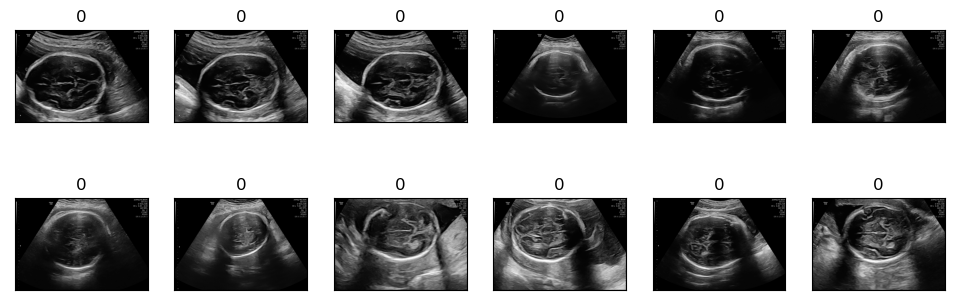

<Figure size 640x480 with 0 Axes>

In [12]:
show_imgs('Voluson S10', 0)

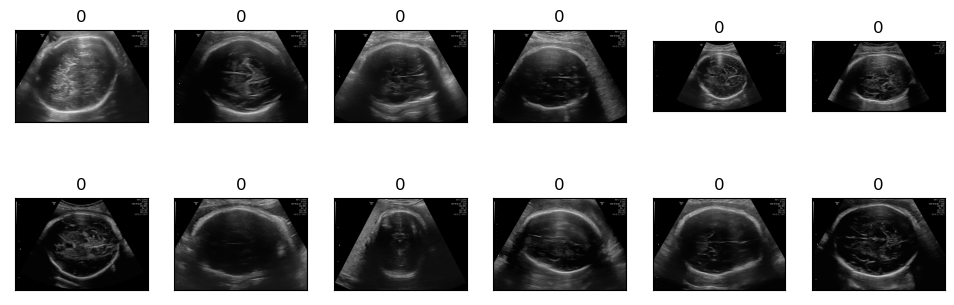

<Figure size 640x480 with 0 Axes>

In [13]:
show_imgs('Other', 0)

# Decision 1: keep Voluson E6 and Aloka, and drop the rest of the machines?

In [14]:
# if so:
df = df[df['US_Machine'].isin(['Voluson E6', 'Aloka'])].reset_index(drop=True)
df = df.drop(columns=['US_Machine'])
# check total #
df.shape


(2578, 2)

<AxesSubplot: >

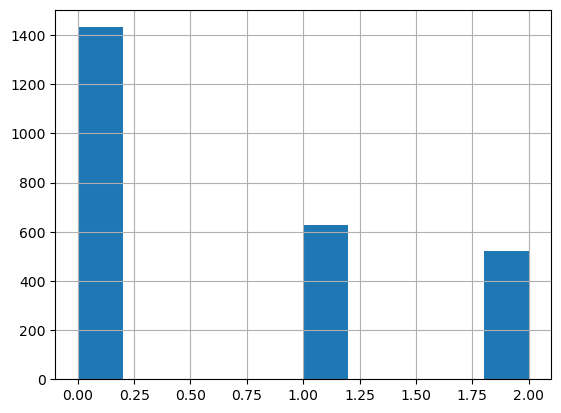

In [15]:
df['Brain_plane'].hist()


# Decision 2: How to deal with Trans-thalamic data?

Possible approach 1: equalize class sizes by randomly dropping samples from Trans-thalamic<br>
Possible approach 2: do nothing; train three models on each of the classes, or something else.

In [16]:
# if approach 1:
trans_thalamic = df[df['Brain_plane'] == 0]
trans_thalamic_index = np.random.choice(trans_thalamic.index, size=800, replace=False)
df_equalized = df[~df.index.isin(trans_thalamic_index)]
df_equalized.shape


(1778, 2)

<AxesSubplot: >

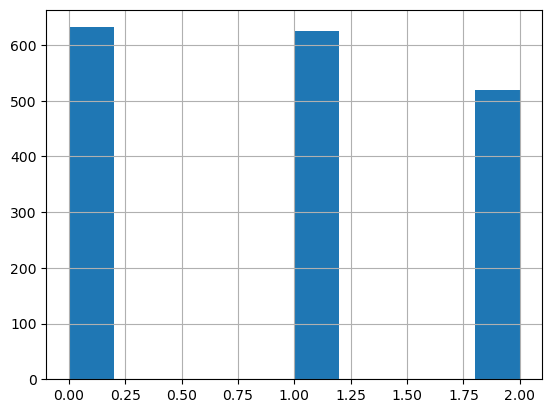

In [17]:
df_equalized['Brain_plane'].hist()


In [18]:
with zipfile.ZipFile('data_equalized.zip', 'w') as myzip:
    for i in df_equalized['Image_name'].values:
        file_path = 'Images/' + i + '.png'
        myzip.write(file_path)

df_equalized.to_csv('data_equalized.csv')


In [19]:
# if approach 2:
with zipfile.ZipFile('data.zip', 'w') as myzip:
    for i in df['Image_name'].values:
        file_path = 'Images/' + i + '.png'
        myzip.write(file_path)

df.to_csv('data.csv')
